# Success factors study

## Introduction

Our team is interested in analysing what factors positively or negatively affect academic success of university students. In our proposal, we explained that we wanted to collect multiple habits and metrics from students and analyse how each of those metrics have an impact of GPA. However, after learning about hypothesis testing we realised that our hypthesis was wrongly formulated and outside the scope and requirements of this project. So we revised our hypothesis.<br>

Lets, start from the begining. Our target population is undergraduate university students who attend any of the following universities schools: Concordia, McGill, UQAM, UdeM, Sherbrooke. The feature we are interesting in investigating is GPA. <br>

We created a survey and asked the following questions:<br>

1. What faculty are you in?

2. On average how many courses do you take per semester? (only take into account fall/winter semesters)

3. How many hours do you work per week at a job unrelated to school?

4. On average, how many days in a week do you not study at all? By studying we mean any work that you do for school. Don't include attending lectures/tutorials/labs
5. On a day that you do study, how many hours do you study?
6. What is the scale of your GPA (out of 4.3 or 4.0)?
7. Finally, what is your gpa?

After a lot of discussion and asking around, we made an educated guess that the average GPA is 3.2



## Data pre-processing
Before starting any numerical analysis, we have to clean the collected data so that it is ready for statistical analysis. 

Below is just some boiler plate code importing the libraries that we need and performing some setup.

You can skip to our *Statistical analysis* section.


In [54]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
from pprint import pprint
from collections import Counter
from matplotlib import pyplot as plt

import math
import csv
import scipy.stats as stats

Z_from_probability = stats.norm.ppf
probability_of_Z = stats.norm.cdf

# list respondents who gave fake answers or made mistakes in answering.
# They have to be removed from the analysis in order not to skew the results
blacklisted_emails = [
    'CleanYourData@Hal3anneh.com',
    'nope@hotmail.com',
    'eyePISSEDandFARDEDandSHIDDEDandCAMEallOVERthePLACE@lmao.pwned.com',
    'chadi.sargi@gmail.com'
]

original_survey = "./data/condensed.actual.latest.csv"
numerical_survey = './data/condensed.numerical.latest.csv'

### Cleaning Data
This function cleans the data from the csv file. We remove all emails for anonymity and unecessary metadata.

In [14]:
def clean(survey_filename: str):
    '''
    Remove the data points where people purpusefully tried to lie.
    Remove all metadata unrelated to business logic
    '''
    file = survey_filename
    numerical_raw_survey = pd.read_csv(file)
    total_rows = len(numerical_raw_survey.index)

    #print(total_rows)

    indexes_to_be_removed = []

    for i in range(1, total_rows):
        email_of_respondent = numerical_raw_survey.iloc[i, 17]
        gpa_of_respondent = float(numerical_raw_survey.iloc[i, 16])
        if email_of_respondent in blacklisted_emails or gpa_of_respondent <= 0.1:
            indexes_to_be_removed.append(i)

    numerical_raw_survey = numerical_raw_survey.drop(
        axis=0, index=indexes_to_be_removed)
    #print(len(numerical_raw_survey.index))

    # only keep answers to survey questions, exclude the faculty question
    # 17 is the index of the email column
    responses = numerical_raw_survey.iloc[1:, list(range(11, 17))]

    # cast string entries to float
    responses = pd.DataFrame.astype(responses, float)
    return responses




# Generate the dataframe object to be analysed
data = clean(numerical_survey)

## Statistical analysis


#### First, let's just plot the GPAs on the y-axis against the respondents on the x-axis
i.e. a point (x,y) just means that the x-th respondent has a GPA of y

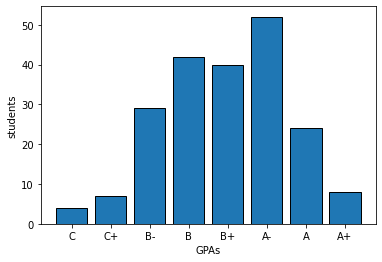

In [100]:
grades_map = {}

for key, letter in enumerate(['A', 'B', 'C', 'D']):
    for offset, modifier in [(0.3, '+'), (0, ''), (-0.3, '-')]:
        numerical_gpa = 4 - key + offset
        letter_grade = letter + modifier
        grades_map[letter_grade] = {
            'gpa': numerical_gpa,
            'students': []
        }
# pprint(grades_map, indent=4)

def category(gpa: float, grades_map: dict) -> tuple:
    '''Return the letter grade closest to the gpa'''
    gpa_distance_tuple = [
        (gpa, grades_map[g]['gpa'], (gpa-grades_map[g]['gpa'])**2) for g in grades_map
    ]
    closest_match = min(gpa_distance_tuple, key=lambda x: x[2])
    return closest_match

def plot_gpas(data, grades_map: dict) ->None:
    q = data.columns
    gpas = data[q[5]].values
    grades = [category(gpa, grades_map)[1] for gpa in gpas]
    bar_chart = Counter(grades)
    hist = sorted(bar_chart.items())
    histogram = {}
    for gpa, count in hist:
        letter = max([g if grades_map[g]['gpa'] == gpa else '' for g in grades_map ])
        histogram[letter] = count

    
    plt.bar(histogram.keys(), histogram.values(), edgecolor = 'black')
    plt.xlabel("GPAs")
    plt.ylabel("students")
    plt.show()

plot_gpas(data, grades_map)

You can see that the lowest gpas are a little bellow 2 and the highest is 4.3 with a little over 200 respondents

### Basic sample attributes
Next up, we write the code for extracting crucial information for our analysis. Namely, we are looking for sample mean, variance, standard deviation, and median.

In [32]:
# extract GPAs from dataframe
def gpa_list(data):
    return list(data.iloc[:, 5])

def sample_size(data):
    return len(data.index)

def mean_gpa(data):
    gpas = gpa_list(data)
    sample_mean = sum(gpas)/len(gpas)
    return sample_mean


def sample_gpa_variance(data):
    # Extract gpas as numpy array to propagate math operations without looping
    # over each element.
    gpas = np.array(gpa_list(data))
    variance = (sum(gpas**2) - sum(gpas)**2/len(gpas)) / (len(gpas)-1)
    return variance


def std_dev_gpa(data):
    return math.sqrt(sample_gpa_variance(data))


def median_gpa(data):
    gpas = gpa_list(data)
    midpoint = int(len(gpas)/2)
    if len(gpas) % 2 == 0:
        return gpas[midpoint]
    lower = gpas[midpoint]
    upper = gpas[midpoint+1]
    median = (lower+upper)/2
    return median


#### Now let's compute them and print them
$\bar{x}$, $S^{2}$, $S$ and median are show below: 

In [35]:
n = sample_size(data)
xbar = round(mean_gpa(data),3)
S_squared = round(sample_gpa_variance(data),3)
S = round(std_dev_gpa(data),3)

print("sample size:", n)
print("mean:", xbar)
print("variance:", S_squared)
print("standard dev:", S)
print("median:", median_gpa(data))

sample size: 206
mean: 3.289
variance: 0.269
standard dev: 0.518
median: 3.4


### Testing for Normality
Since practically forever, We have been hearing profs say that they create normal distributions out of final percent grades to assign letter grades. Because GPA is technically just a linear combination of final grades, there is a high chance that it is also normally distributed.

However, we did not want to make such an assumption without first seeing some evidence to back it up.

To test for normality we will use a technique called normal plotting. First sort all GPAs in order and assign them a value j corresponding to their order in the list (i.e. the smallest GPA is assigned $j=1$ and the largest GPA is assigned $j=n$, where n is the number of total GPAs. By computing the bellow formula and plotting it's result against the corresponding GPAs we can visualise the data distribution. If a linear regression closely approximates the data than it is safe to assume that the underlying data is normally distributed.

The functions bellow uses the following procedure to test sample data.

 
\begin{align}
Y_{j} = \frac{(j - 0.5)}{n} \\
X_{j} = GPA_{j}
\end{align}

```For each j from 1 to n plot``` \begin{align}(x_{j},y_{j})\end{align}

Text(0.5, 1.0, 'Normal Test')

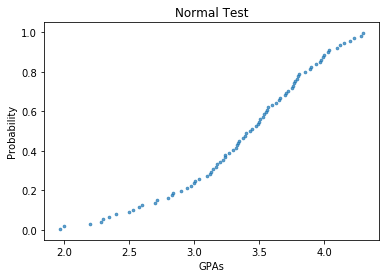

In [40]:
js = [j+1 for j in range(0, len(gpa_copy))]
prob_dis = [(j-0.5) / (len(js)) for j in js]

plt.scatter(gpa_copy, prob_dis, s=7, alpha=0.7)
plt.xlabel('GPAs')
plt.ylabel('Probability')
plt.title('Normal Test')

Text(0.5, 1.0, 'Best Fit Line')

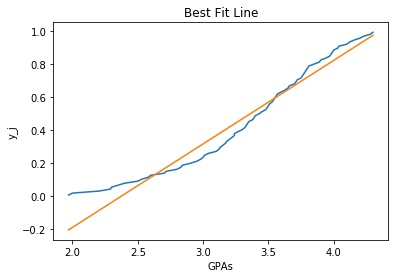

In [41]:
b, m = polyfit(gpa_copy, prob_dis, 1)
plt.plot(gpa_copy, prob_dis)
plt.plot(gpa_copy, b + m * gpa_copy, '-')
plt.xlabel('GPAs')
plt.ylabel('y_j')
plt.title('Best Fit Line')

The points are quite close to their linear regression and we feel it is safe to proceed forward with the assumption that GPAs are normally distributed.

## Hypothesis Testing
### Step 1-3
For this study, the mean $\mu$ of the GPAs collected is our parameter of interest and we  decided to conduct a two-sided test because, if we are wrong about the mean, we don't know in advance whether the true mean is higher or lower than our initial guess.

$H_{0}$: $\mu = 3.2$ 

$H_{1}$: $\mu \neq 3.2$

We wish to test the following hypothesis with 98% confidence. Therefore $\alpha = 2\% = 0.02$


### Step 4 
Our sample size is $n = 206$ and since $n>30$ we can use the Z-distribution instead of the T-distribution even though we don't know the true population variance.

$Z_{\bar{x}}= \frac{\bar{x}-\mu}{s / \sqrt{n}}$


#### Test statistic
below you can find the code to calculate the test statistic $Z_{\bar{x}}$ given a sample mean, population mean, population standard deviation and sample size. As mentioned earlier, we will use sample standard deviation as an accurate estimator of the true $\sigma$ given our large sample size

In [54]:
def calculate_Z_value(mu0, X_bar, S, n):
    # because our sample size is greater than 200, we feel confident of
    # estimating sigma using S. In this way we can use the Z-distribution
    # instead of the T-distribution. This is often done when n > 30.
    Z = (X_bar - mu0)/(S/math.sqrt(n))
    return Z

### Step 5

#### if 
$\pm Z_{\bar{x}}< \pm Z_{ \alpha/2}$

Then we will reject our null hypothesis because it would indicate that we have less than a 2% chance to obtain a sample mean of 3.289 if $\mu = 3.2$.

Below you can see the code for computing the critical values (i.e $\pm Z_{ \alpha/2}$) and the $p-value$

In [62]:
def find_Z_alpha(confidence):
    alpha = 1-confidence
    Z_alpha_over2 = abs(Z_from_probability(1-alpha/2))
    return alpha, Z_alpha_over2

def calculate_p_value(Z):
    p_value = 2*probability_of_Z(-abs(Z))
    return p_value

### Step 6
#### Let's perform all necessary computations to test our hypthesis


In [65]:
confidence_level = 0.98
alpha, cutoff_Z = find_Z_alpha(confidence_level)
alpha = round(alpha,3)
cutoff_Z = round(cutoff_Z,3)
print("alpha:", alpha)
print("Z_alpha/2:", cutoff_Z)
print()

Z = round(calculate_Z_value(3.2,xbar,S,n),3)
print("given our data our test statistic Z =",Z)
print()

if abs(Z)> abs(cutoff_Z):
    print("It appears that our test statistic lands beyond the critical values.")
else:
    print("The test statistic lands in the accepted interval of values (i.e the confidence interval)")
print()


p = calculate_p_value(Z)
p = round(p,3)
print("The P-value for our sample is:",p)
print()

if p < alpha:
    print("We can safely reject the null hypothesis as p={} < alpha={}".format(p,alpha))

alpha: 0.02
Z_alpha/2: 2.326

given our data our test statistic Z = 2.466

It appears that our test statistic lands beyond the critical values.

The P-value for our sample is: 0.014

We can safely reject the null hypothesis as p=0.014 < alpha=0.02


### Step 7: interpretation

The $p-value$ essential says: "if your initial hypothesis is true, then you have a $p$ chance of getting the results shown by your sample data". In this case our $p-value$ is 0.014 which means that we only have a 1.4% chance of getting a sample mean of 3.289 if the true mean was 3.20.

So we reject our initial hypothesis. 

### Alternate hypothesis

Let's see if we can find an alternate hypothesis that is more plausible. given that 3.289 is much closer to 3.30 than it is to 3.20 lets see if it is a reasonable hypothesis to assume that the population mean is equal to 3.30.

In [81]:
new_Z = abs(calculate_Z_value(3.3,xbar,S,n))
new_Z = round(new_Z,4)

new_p = round(calculate_p_value(new_Z),3)
print("The new test statistic is:",new_Z)
print("The new p value is:",new_p)

The new test statistic is: 0.3048
The new p value is: 0.761


This $p-value$ is well above $\alpha$. In fact what this says is that if the true mean is $3.3$ than we have a $76.1\%$ chance of obtaining a sample mean of $3.289$ (or farther from $\mu$). Since this is a very plausible scenario we fail to reject the alternate hypothesis.

### Analysing Type I & II Error

Recall that Type I error is the probability to reject $H_{0}$ when it is true. That is, by definition, the value of $\alpha$... $\alpha = 1 - confidence$. So our Type I error is $2\%$

Type 2 Error (i.e. $\beta$) is the probability of failing to reject $H_{0}$ when it is false. For this, we will keep our alternate hypothesis value of $\mu = 3.3$. To understand this better, imagine two normal distributions: one for $H_{0}$, and one for $H_{1}$ slightly to the right of the first. $\beta$ is the area under the second distribution bounded by the critical values of the first distribution.


Following the formula for $\beta$
\begin{align}
\beta = \phi[Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}] - \phi[-Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}]
\end{align}

Gives us:

In [87]:
def beta_error(Zalpha2, sigma, n, mu0=3.2, mu1=3.3):
    old_Z = abs(Zalpha2)
    diff = (mu1-mu0)*math.sqrt(n)/sigma
    beta = probability_of_Z(old_Z-diff) - probability_of_Z(-old_Z-diff)
    return beta


beta = beta_error(cutoff_Z, S, n)
print("beta error:", round(beta,3))
print("power of test:", round(1-beta,3))

beta error: 0.328
power of test: 0.672


We see that we have $33\%$ chance of accepting our $H_{0}$ when it is false, which is pretty high. To reduce that error, one would need to increase the sample size.

## Discussion

#### Limitations:

First of all, the method of collecting our sample was pseudo-random. We created an online survey and blasted links on social media pages and groups to get our friends and friends of friends to take the survey. Therefore the data might have some bias in that we are not sure if our social circles are good enough representations of the population that we are studying: undergrad students of the 5 above mentioned universities. In fact one thing is for sure, social circles are not random phenomena, and therefore there probably is bias in the data. What the bias is and to what extent it skews the data are questions that are well beyond the scope of this project and that we won't even attempt to answer, (simply because we have no clue) hoping that the bias is small enough.

Second of all, the whole study is predicated on the assumption that GPAs are normally distributed. We have some decent reasons to make that assumption but we are not sure that the linear regression presented in the section on normal testing is close enough for that assumption to be made. The reason for this is that the textbook is not at all clear on the  criteria for what makes the regression "close enough" to the data points. If our logic is flawed regarding this specific topic, then our whole hypothesis and numerical analysis is not worth much.

Third, the GPAs that we collected are as accurate as people have been truthfull. We don't expect people to lie about their GPAs because we don't see the motive or the incentive but that remains something to consider.

#### Expansion of scope:

As mentioned in the introduction, we initially wanted to collect metrics to be able to predict the GPA of a student given some data about their studying habits. We quickly found that this was outside of the scope and requirement of the project, so we adapted our hypothesis. However we are still very interested in seeing if we can accurately predict GPAs. If we are able to make something worthwhile out of the collected data we will make sure to post our results at the following [link](http://stats.study.ribalaladeeb.com).